<a href="https://colab.research.google.com/github/WinthropFin/WinthropFinance/blob/master/VaR_calculation_of_stock_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install quandl
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import quandl
quandl.ApiConfig.api_key = "zm2jjavJ-s6a5YbZygE3"

In [24]:
AAPL = quandl.get('EOD/AAPL', collapse = 'daily')

In [25]:
AAPL.tail()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2017-12-21,174.17,176.020,174.100,175.01,20949896.0,0.0,1.0,41.703509,42.146476,41.686748,41.904640,83799584.0
2017-12-22,174.68,175.424,174.500,175.01,16349444.0,0.0,1.0,41.825624,42.003768,41.782525,41.904640,65397776.0
2017-12-26,170.80,171.470,169.679,170.57,33185536.0,0.0,1.0,40.896591,41.057017,40.628178,40.841520,132742144.0
2017-12-27,170.10,170.780,169.710,170.60,21498213.0,0.0,1.0,40.728982,40.891803,40.635600,40.848703,85992852.0
2017-12-28,171.00,171.850,170.480,171.08,16480187.0,0.0,1.0,40.944480,41.148005,40.819970,40.963635,65920748.0


In [26]:
rets_1 = (AAPL['Close']/AAPL['Close'].shift(1))-1
rets_1.head()

Date
2013-09-03         NaN
2013-09-04    0.020695
2013-09-05   -0.006860
2013-09-06    0.005956
2013-09-09    0.015957
Name: Close, dtype: float64

In [27]:
mean = np.mean(rets_1)
std = np.std(rets_1)
Z_99 = stats.norm.ppf(1-0.99)
price = AAPL.iloc[-1]['Close']
x= np.linspace(mean - 3*std, mean + 3*std, 100)
print(mean, std, Z_99, price)

0.00012614510101787468 0.02959836238274855 -2.3263478740408408 171.08


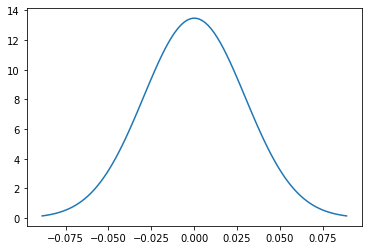

In [28]:
plt.plot(x, stats.norm.pdf(x, mean, std))
plt.show()

In [29]:
ParamVAR = price*Z_99*std
HistVAR = price*np.percentile(rets_1.dropna(), 1)

print('Parametric VAR is {0:.3f} and Historical VAR is {1:.3f}'
      .format(ParamVAR, HistVAR))

Parametric VAR is -11.780 and Historical VAR is -6.704


# For Monte Carlo simulation, we simply apply a simulation using the assumptions of normality, and the mean and std computed above.


In [30]:
np.random.seed(42)
n_sims = 1000000
sim_returns = np.random.normal(mean, std, n_sims)
SimVAR = price*np.percentile(sim_returns, 1)
print('Simulated VAR is ', SimVAR)

Simulated VAR is  -11.778152416832436


## Historical return - bootstraping


In [31]:
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt
 
quandl.ApiConfig.api_key = "zm2jjavJ-s6a5YbZygE3"
 
symbols = ["WIKI/AAPL.4"]
data = quandl.get(symbols, start_date="2015-12-31", end_date="2017-10-31", collapse="daily")
rets = data.pct_change()
rets = rets[1:]
price = AAPL.iloc[-1]['Close'] 
daily_vol = rets.std()
daily_ret = rets.mean()
    
simulation_df = pd.DataFrame()
 
num_simulations = 10000
predicted_days = 252
 
last_price = data.iloc[-1:,0]
last_price = last_price[0]

In [32]:
# estimate mean and std
retMean = np.mean(rets)
retStd = np.std(rets)
nsamp = len(rets)
# define price one day in future
pFut = price*(1.+rets)

# VaR probability level
p = 0.05
# Historical VaR
PStar = np.percentile(pFut,100*p)
VaRHist = price-PStar

print(retMean, retStd, nsamp, PStar,price, VaRHist)

WIKI/AAPL - Close    0.001116
dtype: float64 WIKI/AAPL - Close    0.013275
dtype: float64 461 167.3889704142012 171.08 3.691029585798816


## The code below draws 1000 times from the return sample with replacement and calculated the possible price change from lastest price to predict the future¶


In [33]:
ret = rets.iloc[:,0]
nboot = 1000
VaRDist = np.zeros(nboot)

for trial in range(nboot):
    retsim = np.random.choice(ret,size=nsamp)
    pFut = price*(1+retsim)
    PStar = np.percentile(pFut,100.*p)
    VaRDist[trial] = price-PStar

# Percentile method
confBand = np.percentile(VaRDist,(2.5,97.5))
fmt = "%6.4f %6.4f %6.4f"
print(fmt%(confBand[0], VaRHist, confBand[1]))

# Normal approximation
VaRStd = np.std(VaRDist)
a1 = stats.norm.ppf(0.025)
a2 = stats.norm.ppf(0.975)
    
fmt = "%6.4f %6.4f %6.4f"
print(fmt%(VaRHist+a1*VaRStd, VaRHist, VaRHist+a2*VaRStd))

# Bootstrap summary
print(stats.describe(VaRDist))

2.8508 3.6910 4.1085
3.0385 3.6910 4.3436
DescribeResult(nobs=1000, minmax=(2.491100642398294, 4.39851540616246), mean=3.591171786456287, variance=0.11096491869958434, skewness=-0.4761915227706666, kurtosis=-0.12097952778303922)


## Single asset Var calculation


In [34]:
symbol = "WIKI/AAPL.4"
data = quandl.get(symbol, start_date="2015-12-31", end_date="2017-10-31", collapse="daily")
data.head()    
    

,Close
Date,
2015-12-31,105.26
2016-01-04,105.35
2016-01-05,102.71
2016-01-06,100.70
2016-01-07,96.45


In [35]:
def single_asset_var():
    #Get data from quandl

    #Calculate returns
    rets = data.pct_change()
    rets = rets.dropna(how='any') 
    
    #Sort Returns in Ascending Order
    sorted_rets = sorted(rets["Close"])
    
    varg = np.percentile(sorted_rets, 5)
    
    #Output histogram
    plt.hist(sorted_rets)
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title(r'Histogram of Asset Returns', fontsize=18, fontweight='bold')
    plt.axvline(x=varg, color='r', linestyle='--', label='95% Confidence VaR: ' + "{0:.2f}%".format(varg * 100))
    plt.legend(loc='upper right', fontsize = 'x-small')
    plt.show()
    
    #VaR stats
    print("99.99% Confident the actual loss will not exceed: " , "{0:.2f}%".format(np.percentile(sorted_rets, .01) * 100))
    print("99% Confident the actual loss will not exceed: " + "{0:.2f}%".format(np.percentile(sorted_rets, 1) * 100))
    print("95% Confident the actual loss will not exceed: " + "{0:.2f}%".format(np.percentile(sorted_rets, 5) * 100))

    print("Losses expected to exceed " + "{0:.2f}%".format(np.percentile(sorted_rets, 5) * 100) + " " + str(.05*len(rets)) + " out of " + str(len(rets)) + " days")

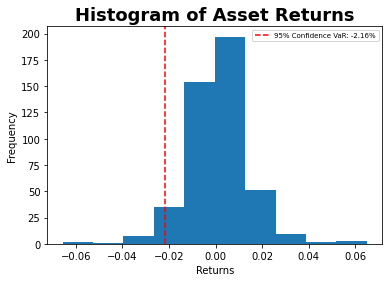

99.99% Confident the actual loss will not exceed:  -6.56%
99% Confident the actual loss will not exceed: -3.45%
95% Confident the actual loss will not exceed: -2.16%
Losses expected to exceed -2.16% 23.05 out of 461 days


In [36]:
single_asset_var()